In [2]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [3]:
#Shamelessly lifted from Jon's branch
bridge = pd.read_csv("../data/bridge.csv")
dim_claims = pd.read_csv("../data/dim_claims.csv")
dim_date = pd.read_csv("../data/dim_date.csv")
dim_pa = pd.read_csv("../data/dim_pa.csv")

In [4]:
df2 = bridge.merge(dim_claims, on='dim_claim_id', how='left').copy()
df4 = df2.merge(dim_pa, on='dim_pa_id', how='left').copy()

df4.head(10)

,dim_claim_id,dim_pa_id,dim_date_id,bin,drug,reject_code,pharmacy_claim_approved,correct_diagnosis,tried_and_failed,contraindication,pa_approved
0,1,1.0,1,417380,A,75.0,0,1.0,1.0,0.0,1.0
1,2,NaN,1,999001,A,NaN,1,NaN,NaN,NaN,NaN
2,3,2.0,1,417740,A,76.0,0,1.0,0.0,0.0,1.0
3,4,NaN,1,999001,A,NaN,1,NaN,NaN,NaN,NaN
4,5,NaN,1,417740,A,NaN,1,NaN,NaN,NaN,NaN
5,6,NaN,1,417740,A,NaN,1,NaN,NaN,NaN,NaN
6,7,NaN,1,999001,A,NaN,1,NaN,NaN,NaN,NaN
7,8,NaN,1,417740,A,NaN,1,NaN,NaN,NaN,NaN
8,9,NaN,1,999001,A,NaN,1,NaN,NaN,NaN,NaN
9,10,3.0,1,417380,A,75.0,0,0.0,0.0,1.0,1.0


In [5]:
df4 = df4.fillna(-1)
df4.head()

,dim_claim_id,dim_pa_id,dim_date_id,bin,drug,reject_code,pharmacy_claim_approved,correct_diagnosis,tried_and_failed,contraindication,pa_approved
0,1,1.0,1,417380,A,75.0,0,1.0,1.0,0.0,1.0
1,2,-1.0,1,999001,A,-1.0,1,-1.0,-1.0,-1.0,-1.0
2,3,2.0,1,417740,A,76.0,0,1.0,0.0,0.0,1.0
3,4,-1.0,1,999001,A,-1.0,1,-1.0,-1.0,-1.0,-1.0
4,5,-1.0,1,417740,A,-1.0,1,-1.0,-1.0,-1.0,-1.0


In [6]:
df4.shape

(1335576, 11)

In [7]:
min(df4[(df4.pharmacy_claim_approved == 0)].dim_pa_id)

1.0

In [8]:
pa = df4[df4.pharmacy_claim_approved == 0].copy()
y = pa['pa_approved']

X_train,X_test,y_train,y_test = train_test_split(pa,y,
                                                 test_size = .25,
                                                 random_state = 614,
                                                 shuffle = True,
                                                 stratify = y)


In [9]:
codes = X_train['reject_code'].unique()
print(codes)
#X_train = X_train[X_train.pharmacy_claim_approved == 0]
#y_train = X_train['pa_approved']


for code in codes:
    if(code != -1): 
        pa_approved = X_train[(X_train.reject_code == code) & (y_train == 1)].shape[0]
        pa_req = X_train[(X_train.reject_code == code) & (X_train.dim_pa_id > 0)].shape[0]
        if(pa_req == 0): 
            app_rate = -99
        else:
            app_rate = pa_approved/pa_req
        print("Reject Code ",code,"has approval rate of ",app_rate)

[75. 76. 70.]
Reject Code  75.0 has approval rate of  0.9485268843604223
Reject Code  76.0 has approval rate of  0.8846700664503168
Reject Code  70.0 has approval rate of  0.49889876566684094


In [10]:
#Hot Code Rejection Codes

rcd = pd.get_dummies(X_train['reject_code'])
X_train['not_in_formulary'] = pd.get_dummies(X_train['reject_code'])[70.0]
X_train['limit_exceeded'] = pd.get_dummies(X_train['reject_code'])[76.0]

#Hot Code drugs

X_train['Drug A']=pd.get_dummies(X_train['drug'])['A']
X_train['Drug B']=pd.get_dummies(X_train['drug'])['B']

#Hot Code Payers! (only difference so far)

payers = X_train['bin'].unique()
#print(payers)

for payer in payers:
    if(payer != 999001): 
        print(payer)
        X_train[payer] = pd.get_dummies(X_train['bin'])[payer]
        
X_train.head()


417380
417740
417614


<ipython-input-10-6371717ab115>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['not_in_formulary'] = pd.get_dummies(X_train['reject_code'])[70.0]
<ipython-input-10-6371717ab115>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['limit_exceeded'] = pd.get_dummies(X_train['reject_code'])[76.0]
<ipython-input-10-6371717ab115>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

,dim_claim_id,dim_pa_id,dim_date_id,bin,drug,reject_code,pharmacy_claim_approved,correct_diagnosis,tried_and_failed,contraindication,pa_approved,not_in_formulary,limit_exceeded,Drug A,Drug B,417380,417740,417614
13591,13592,5646.0,13,417380,A,75.0,0,1.0,1.0,1.0,1.0,0,0,1,0,1,0,0
187311,187312,77709.0,176,999001,B,76.0,0,1.0,0.0,0.0,1.0,0,1,0,1,0,0,0
922500,922501,383552.0,787,417380,C,70.0,0,1.0,0.0,0.0,1.0,1,0,0,0,1,0,0
1164431,1164432,484306.0,963,417740,B,70.0,0,1.0,0.0,0.0,0.0,1,0,0,1,0,1,0
330539,330540,136991.0,313,417740,B,70.0,0,1.0,0.0,0.0,0.0,1,0,0,1,0,1,0


In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
# import cross-validation
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [12]:
features = ['correct_diagnosis','tried_and_failed','contraindication',
           'not_in_formulary','limit_exceeded','Drug A','Drug B',417380, 417740, 417614]
X_train = X_train[features] 

X_train.head()
X_train.shape

(416963, 10)

In [13]:
f=10
kfold = StratifiedKFold(f,shuffle=True,random_state=440)

In [ ]:
cutoffs = np.arange(0.0,1.0,.02)
z=0

accs = np.zeros((f,len(cutoffs)))
precs = np.zeros((f,len(cutoffs)))
recs = np.zeros((f,len(cutoffs)))
f1s = np.zeros((f,len(cutoffs)))

log_reg = LogisticRegression()


#y_prob = log_reg.predict_proba(X_train[features])[:,1] #Probability of Approval
fold = 0

for train_index,test_index in kfold.split(X_train,y_train):
    #print(train_index)
    #print(test_index)
    y_train_train,y_train_test = y_train.iloc[train_index],y_train.iloc[test_index]
    X_train_train =X_train.iloc[train_index]
    X_train_test = X_train.iloc[test_index]
    print("Now training fold",fold+1,"of",f)

    for j in range(len(cutoffs)):
        log_reg_clone = clone(log_reg)
        log_reg_clone.fit(X_train_train,y_train_train)
        probs = log_reg_clone.predict_proba(X_train_test)[:,1]
        
        y_pred = 1*(probs > cutoffs[j])
        accs[fold,j] = accuracy_score(y_train_test,y_pred)
        precs[fold,j] = precision_score(y_train_test,y_pred,zero_division=z)
        recs[fold,j] = recall_score(y_train_test,y_pred,zero_division=z)
        f1s[fold,j] = f1_score(y_train_test,y_pred,zero_division=z)
    fold=fold+1

print("Training Done!")

Now training fold 1 of 10


[0.36 0.38 0.4  0.42 0.44 0.46 0.48]
[0.95886873 0.9417775  0.9417775  0.93911291 0.93684345 0.93684345
 0.93684345]
0
Our optimal cutoff at 0.36 gives is a recall of  0.96 with a precision of 0.81


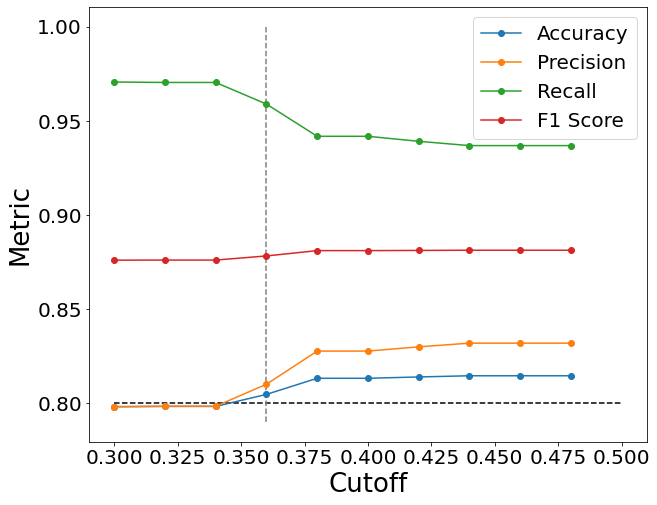

In [38]:
prec_guard = 0.8
prec = np.mean(precs,axis=0)
rec = np.mean(recs,axis=0)

prec2 = prec[prec>prec_guard]
rec2 = rec[prec>prec_guard]


print(cutoffs[prec>prec_guard])


#Find Highest recall with precision greater than guardrail value

print(rec2)
print(np.argmax(rec2))

l = np.argmax(rec2)
cot = cutoffs[prec>prec_guard]

print("Our optimal cutoff at",np.round(cot[l],2),"gives is a recall of ",np.round(rec2[l],2),
      "with a precision of",np.round(prec2[l],2))


plt.figure(figsize=(10,8))

plt.plot(cutoffs,np.mean(accs,axis=0),'o-',label="Accuracy")
plt.plot(cutoffs,np.mean(precs,axis=0),'o-',label="Precision")
plt.plot(cutoffs,np.mean(recs,axis=0),'o-',label="Recall")
plt.plot(cutoffs,np.mean(f1s,axis=0),'o-',label="F1 Score")


plt.xlabel("Cutoff", fontsize=26)
plt.ylabel("Metric", fontsize=26)

plt.legend(fontsize=20)

plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.hlines(y=0.8,xmin=0.3,xmax=0.5,color='black',linestyles='dashed')
plt.vlines(x=cot[l],ymin=0.79,ymax=1.0,color='gray',linestyles='dashed')


plt.savefig("AllLogReg_zoom.jpg")
plt.show()




## Retrain on entire training set and Pickle

In [40]:
import pickle


In [41]:
log_reg_train = LogisticRegression()
log_reg_train.fit(X_train,y_train)





LogisticRegression()

In [45]:
#Pickle!

outfile = open('log_reg.pcl','wb')
pickle.dump(log_reg_train,outfile)
outfile.close()

In [44]:
#log_reg_clone.predict_proba(X_train_test)[:,1]

X_train_test.head()

print(features)


['correct_diagnosis', 'tried_and_failed', 'contraindication', 'not_in_formulary', 'limit_exceeded', 'Drug A', 'Drug B', 417380, 417740, 417614]
